## Model (Clustering or Association Rules)

* Team : Data Crew

(Clustering for the customers or finding patterns in the data with some association rulel algorithms)

* Libraries required

In [7]:
# Basic Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Librarie for Preprocessing
from utils import *

# Data Structures
from collections import defaultdict

# Model Libraries
import xgboost as xgb

sns.set_style('whitegrid')

* Retrieving the data from the original source

In [4]:
data = pd.read_csv('../../1. Data/smaller_sample.csv')
event_defs = pd.read_csv('../../1. Data/Event+Definitions.csv')

* Data Cleaning and Feature Engineering

In [5]:
df = get_classification_dataset(data, event_defs, n_events=5)
df

,,num_journeys,max_journey,order_shipped,discover,approved_credit,first_purchase,account_activitation,downpayment_received,downpayment_cleared,order_ships,max_milestone,number_accounts,one_more_journey,most_repeated_event,average_length_seq,first_5_events
customer_id,,,,,,,,,,,,,,,,,
5414,0,1,27,False,True,True,False,False,False,False,False,1.0,1,False,browse_products,24.0,"[21, 12, 4, 2, 4]"
26746,0,1,5,False,True,True,False,False,False,False,False,1.0,1,False,application_web_approved,3.0,"[2, 12, 21]"
43085,0,1,30,True,True,True,True,True,True,True,True,6.0,1,False,view_cart,30.0,"[29, 2, 12, 4, 4]"
61659,0,1,7,False,True,True,False,False,False,False,False,1.0,1,False,browse_products,7.0,"[12, 23, 4, 11, 6]"
67034,0,1,22,False,True,True,False,False,False,False,False,1.0,1,False,application_web_view,17.0,"[2, 19, 19, 19, 19]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2147283220,0,1,12,False,True,True,False,False,False,False,False,1.0,1,False,browse_products,11.0,"[12, 4, 4, 4, 4]"
2147340717,0,1,11,False,False,True,False,False,False,False,False,1.0,1,False,campaignemail_clicked,8.0,"[12, 24, 4, 11, 5]"
2147417277,0,1,15,False,False,True,False,False,False,False,False,1.0,1,False,add_to_cart,13.0,"[12, 6, 11, 5, 4]"


### Separating the data and the target

In this case we want the target to be **order_ships** as this is how we are defining a customer journey as successful or not.

In [16]:
y = df['order_ships'].to_numpy()
X = df.drop(columns=['order_ships']).to_numpy()

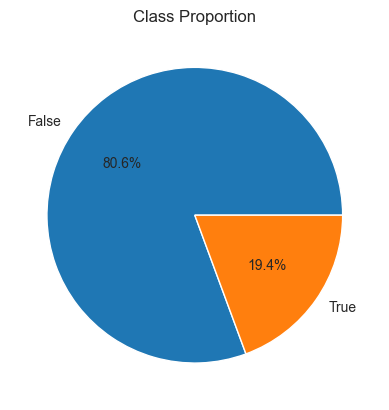

In [25]:
plt.pie(df['order_ships'].value_counts(), labels=df['order_ships'].value_counts().index, autopct='%1.1f%%')
plt.title('Class Proportion')
plt.show()

# Cross Validation

In [61]:
events = set(event_defs['event_name'].unique())

repeated = set(df['most_repeated_event'].unique())

In [70]:
repeated.difference(events)

{'campaignemail_clicked', 'catalog_(mail)'}

In [74]:
set(data['event_name'].unique()).difference(events)

{'campaignemail_clicked',
 'catalog_(email)_(experian)',
 'catalog_(mail)',
 'pre-application_(3rd_party_affiliates)',
 'promotion_created'}

In [75]:
data[data['event_name'] == 'catalog_(mail)']

,customer_id,account_id,stage,ed_id,event_name,event_timestamp,journey_steps_until_end,journey_id,milestone_number
191,1.846874e+09,-385676859,NaN,21,catalog_(mail),2022-04-18,28,NaN,NaN
194,1.846874e+09,-385676859,NaN,21,catalog_(mail),2022-05-16,31,NaN,NaN
457,1.269403e+09,317834409,NaN,21,catalog_(mail),2021-05-17,20,NaN,NaN
459,1.269403e+09,317834409,NaN,21,catalog_(mail),2021-06-14,22,NaN,NaN
466,1.269403e+09,317834409,NaN,21,catalog_(mail),2021-11-15,29,NaN,NaN
...,...,...,...,...,...,...,...,...,...
3246219,7.461185e+08,-1106992491,NaN,21,catalog_(mail),2023-02-13,1,NaN,NaN
3246269,-6.347773e+08,1480276492,NaN,21,catalog_(mail),2023-03-13,1,NaN,NaN
3246290,5.461835e+08,-1528127933,NaN,21,catalog_(mail),2023-06-05,1,NaN,NaN
3246295,-3.026989e+08,-1678926520,NaN,21,catalog_(mail),2023-07-10,1,NaN,NaN


In [77]:
event_defs[event_defs['event_definition_id'] == 21]

,event_name,journey_id,event_definition_id,milestone_number,stage
27,catalog_mail,1,21,NaN,Prospecting


In [50]:
pd.merge(event_defs,df['most_repeated_event'],  left_on='event_name', right_on='most_repeated_event')

,event_name,journey_id,event_definition_id,milestone_number,stage,most_repeated_event
0,application_phone_approved,1,15,1.0,Apply for Credit,application_phone_approved
1,application_phone_approved,1,15,1.0,Apply for Credit,application_phone_approved
2,application_phone_approved,1,15,1.0,Apply for Credit,application_phone_approved
3,application_phone_approved,1,15,1.0,Apply for Credit,application_phone_approved
4,application_phone_approved,1,15,1.0,Apply for Credit,application_phone_approved
...,...,...,...,...,...,...
74050,view_cart,1,5,NaN,First Purchase,view_cart
74051,order_shipped,1,28,6.0,Order Shipped,order_shipped
74052,order_shipped,1,28,6.0,Order Shipped,order_shipped
74053,order_shipped,1,28,6.0,Order Shipped,order_shipped


In [35]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
for train, test in cv.split(X,y):
    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=42)
    xgb_model.fit(X[train], y[train])

ValueError: could not convert string to float: 'view_cart'

## XGBoost